In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
import random
import numpy as np
from tqdm.notebook import tqdm
from tabulate import tabulate
from omnibelt import load_json, save_json
from pathlib import Path
from collections import Counter
import requests
import json
from googlefinance import getQuotes
from bs4 import BeautifulSoup
import requests, sys, lxml.html
# from finquant.portfolio import build_portfolio

# import yfinance as yf
from yahooquery import Ticker

from src import URLS, STRATEGY, extract_html, extract_table, load_etf_snapshot, \
    load_etf_analyst, load_etf_pie, load_etf_holdings, get_yf, get_ticker, \
    get_recommendations, get_fund_holdings, get_fund_sectors, get_type, get_fund_categories, \
    load_stock_snapshot, load_stock_contained, load_stock_history, dicts_to_table, SITES, \
    clear_loaded, load, TYPES, collect, REGIONS

from src import *

In [2]:
names = []
ratios = {}
for group, tickers in STRATEGY.items():
    ratios.update({k:v/100 for k,v in tickers.items()})

names = list(k for k,v in ratios.items() if v > 0)

cats = TYPES.copy()
# cats = {}
# for n in names:
#     t = get_type(n)
#     if t not in cats:
#         cats[t] = []
#     cats[t].append(n)

name = random.choice(names)
name

'ESPO'

In [3]:
sum(ratios.values())

1.0000000000000004

In [4]:
cat = 'ETF'
# cat = 'EQUITY'
group = 'snapshot'
group = 'holdings'

In [5]:
etfs = load('ETF', 'holdings', pbar=tqdm)
pies = load('ETF', 'composition', pbar=tqdm)
stocks = load('EQUITY', 'snapshot', pbar=tqdm)
features = {'Sector': ('company', 'sector'), 
            'Industry': ('company', 'industry'), 
            'Country':('company', 'country'), 
            'Ticker': ('company', 'ticker')}
stocks = collect(stocks, features)
len(etfs), len(pies), len(stocks)

(40, 40, 20)

In [6]:
pies['IAU']

{'Asset Classification': 'Commodity',
 'Investment Philosophy': 'Passively Managed',
 'Holdings': {'Gold': 100.0}}

In [7]:
for ticker, hlds in etfs.items():
    den = sum(row[-1] for row in hlds)
    for row in hlds:
        row[-1] /= den

for ticker, ps in pies.items():
    for key in ['Holdings', 'Sector Exposure', 'Industry Exposure', 'Country Exposure', 
                'Maturity', 'Credit Grade', 'Debt Type', ]:
        if key in ps:
            den = sum(ps[key].values())
            for k,v in ps[key].items():
                ps[key][k] = v / den

In [8]:

companies = {}
countries = {}
sectors = {}
industry = {}
maturity = {}
grades = {}

tbls = {'companies':companies, 'countries':countries, 'sectors':sectors, 
        'industry':industry, 'maturity':maturity, 'grades':grades}

for ticker, ratio in ratios.items():
#     if ratio > 0:
#         if ticker in etfs:
#             info = etfs[ticker]
            
#             for tk, _, land, q in info:
#                 if tk not in companies:
#                     companies[tk] = 0.
#                 companies[tk] += q * ratio
#                 if land not in countries:
#                     countries[land] = 0.
#                 countries[land] += q * ratio
        
    if ticker in stocks:
        info = stocks[ticker]

        if ticker not in companies:
            companies[ticker] = 0.
        companies[ticker] += ratio

        land = info['Country']
        if land not in countries:
            countries[land] = 0.
        countries[land] += ratio

        sec = info['Sector']
        if sec not in sectors:
            sectors[sec] = 0.
        sectors[sec] += ratio

        ind = info['Industry']
        if ind not in industry:
            industry[ind] = 0.
        industry[ind] += ratio

#         else:
#             assert False, f'{ticker}'

    if ticker in pies:
        info = pies[ticker]

        if info['Asset Classification'] == 'Equity':

            if 'Sector Exposure' not in info:
                print(f'{ticker} sector failed')
            else:
                for sec, q in info['Sector Exposure'].items():
                    if sec not in sectors:
                        sectors[sec] = 0.
                    sectors[sec] += q * ratio

            if 'Industry Exposure' not in info:
                print(f'{ticker} industry failed')
            else:
                for ind, q in info['Industry Exposure'].items():
                    if ind not in industry:
                        industry[ind] = 0.
                    industry[ind] += q * ratio

        elif info['Asset Classification'] == 'Fixed Income':

            if 'Bonds' not in sectors:
                sectors['Bonds'] = 0.
            sectors['Bonds'] += ratio

            for t, q in info['Debt Type'].items():
                if t not in industry:
                    industry[t] = 0.
                industry[t] += ratio * q

            for g, q in info['Credit Grade'].items():
                if g not in grades:
                    grades[g] = 0.
                grades[g] += q * ratio

            for m, q in info['Maturity'].items():
                if m not in maturity:
                    maturity[m] = 0
                maturity[m] += q * ratio

        elif info['Asset Classification'] == 'Commodity':
            for mat, q in info['Holdings'].items():
                if mat not in industry:
                    industry[mat] = 0.
                industry[mat] += ratio * q

            if 'Commodity' not in sectors:
                sectors['Commodity'] = 0.
            sectors['Commodity'] += ratio
        else:
            if 'Unknown' not in sectors:
                sectors['Unknown'] = 0.
            sectors['Unknown'] += ratio
#             if 'Unknown' not in countries:
#                 countries['Unknown'] = 0
#             countries['Unknown'] += ratio
#             if 'Unknown' not in companies:
#                 companies['Unknown'] = 0
#             companies['Unknown'] += ratio
            if 'Unknown' not in industry:
                industry['Unknown'] = 0
            industry['Unknown'] += ratio
#                 raise Exception(ticker)

#             if info['Asset Classification'] != 'Commodity':
    if ticker in etfs:
        holdings = etfs[ticker]
        for tk, _, land, q in holdings:
            if tk not in companies:
                companies[tk] = 0.
            companies[tk] += q * ratio
            if land not in countries:
                countries[land] = 0.
            countries[land] += q * ratio

regions = {}
for land, q in countries.items():
    key = REGIONS.get(land, 'Unknown')
    if key not in regions:
        regions[key] = 0.
    regions[key] += q
tbls['regions'] = regions    
        
    
for tbl in tbls.values():
    if None in tbl:
        if 'Unknown' not in tbl:
            tbl['Unknown'] = 0.
        tbl['Unknown'] += tbl[None]
        del tbl[None]
    
sum(countries.values()), sum(companies.values()), sum(sectors.values()), sum(industry.values())

(0.9999999999999244, 0.9999999999999813, 1.0, 1.0000000000000002)

In [9]:
remove_keys(countries, {'Xav Health Care Mar21 Xcme 20210319', 'Xai Emini Industr Mar21 Xcme 20210319', 'XAF FINANCIAL MAR21 XCME 20210319'})

In [10]:
tbls

{'companies': {'TSLA': 0.03228320698867616,
  'AMD': 0.021239210403154463,
  'NVDA': 0.022429539369104575,
  'BABA': 0.025972578496973632,
  'TCEHY': 0.015,
  'AMZN': 0.017167022382370608,
  'MSFT': 0.018592811787292256,
  'COST': 0.010808689529099046,
  'NTDOY': 0.01,
  'DIS': 0.011001666617796916,
  'SHOP': 0.006075038879770481,
  'PDD': 0.007893344531803464,
  'GOOGL': 0.008399177532258472,
  'AAPL': 0.014959195389932452,
  'BIDU': 0.0074709329261781615,
  'SNE': 0.005017992802878848,
  'FB': 0.009374317530496112,
  'PYPL': 0.006319464664763726,
  'NFLX': 0.006311677164871636,
  'NIO': 0.005892211442621151,
  'GOOG': 0.0023997271229281693,
  'BRK.B': 0.0022480649041694556,
  'JNJ': 0.0029644993466432477,
  'JPM': 0.0021947715895353982,
  'V': 0.0018186518263694847,
  'PG': 0.0013883157817870752,
  'UNH': 0.002787280584263083,
  'MA': 0.001530483770434221,
  'HD': 0.0012043335651687418,
  'VZ': 0.0008072472297274885,
  'ADBE': 0.0013588981199163625,
  'CMCSA': 0.0007688089329320629,


In [11]:
regions

{'North America': 0.5684993566526586,
 'Asia': 0.3232549608349028,
 'Europe': 0.07771593863479287,
 'Unknown': 0.013035352680510523,
 'Latin America': 0.008963333661658622,
 'Middle East': 0.006148525069148392,
 'Africa': 0.0023825324662530463}

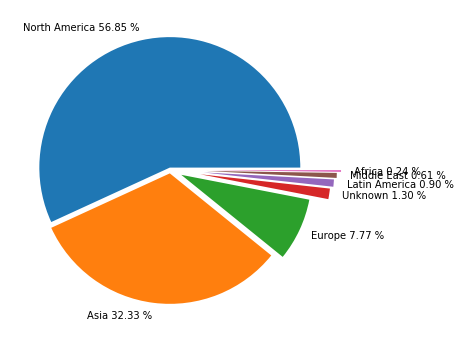

In [12]:
plt.figure(figsize=(6,6))
plt.pie(list(regions.values()), explode=[1/(100*v+3) for v in regions.values()], labels=[f'{k} {v*100:.2f} %' for k,v in regions.items()])
# plt.tight_layout()
pass

In [13]:
print(tabulate([(k,v*100) for k,v in regions.items()], headers=['Region', 'Amount (%)']))

Region           Amount (%)
-------------  ------------
North America     56.8499
Asia              32.3255
Europe             7.77159
Unknown            1.30354
Latin America      0.896333
Middle East        0.614853
Africa             0.238253


In [14]:
def get_top(data, top=None):
    tb = [(k,v*100) for k,v in data.items()]
    tb = sorted(tb, key=lambda x: x[1], reverse=True)
    if top is not None:
        top = tb[:top]
        top.append(('Other', sum(q for _,q in tb) - sum(q for _,q in top)))
        tb = top
    return tb

In [15]:
tbls.keys()

dict_keys(['companies', 'countries', 'sectors', 'industry', 'maturity', 'grades', 'regions'])

In [16]:
key = 'industry'

In [17]:
top = get_top(tbls[key], 49)
print(tabulate(top, headers=[key.capitalize(), 'Amount (%)']))

Industry                                          Amount (%)
----------------------------------------------  ------------
Semiconductors & Semiconductor Equipment            8.42425
Internet & Direct Marketing Retail                  6.46997
Interactive Media & Services                        6.40384
Software                                            5.78335
Unknown                                             5
Automobiles                                         4.77143
Entertainment                                       4.60999
Banks                                               3.89239
IT Services                                         2.99086
Government                                          2.64707
Technology Hardware, Storage & Peripherals          2.56935
Pharmaceuticals                                     2.41569
Chemicals                                           2.27589
Electrical Equipment                                2.22736
Independent Power and Renewable Electricity.

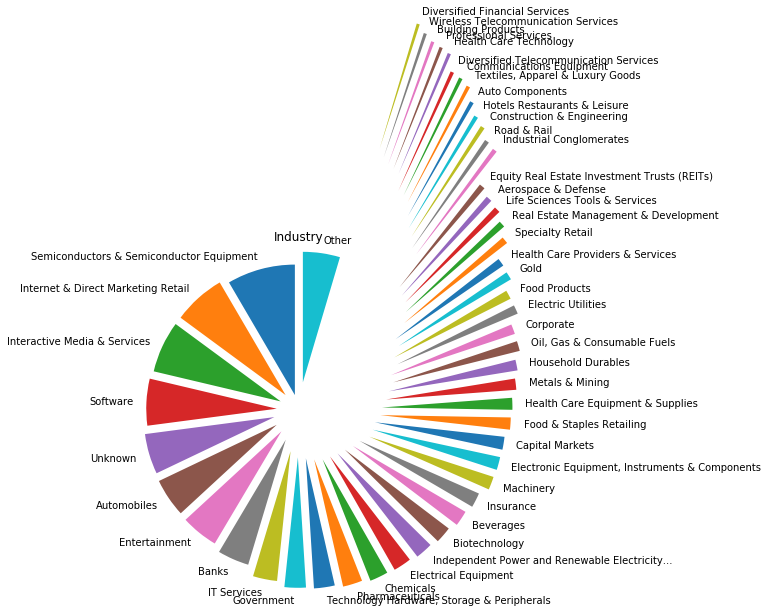

In [33]:
plt.figure(figsize=(6,6))
l,x = list(zip(*top))
plt.pie(x, labels=l, explode=[1/(v+.1) for v in x], startangle=90)
plt.title(key.capitalize())
pass

In [18]:
pies['EMXC']['Regional Exposure']

{'Asia': 66.55,
 'Latin America': 12.62,
 'Middle East': 7.56,
 'Europe': 7.26,
 'Africa': 5.74,
 'North America': 0.27}

In [40]:
# for site in SITES[cat]:
#     for ticker in cats[cat]:
#         print(URLS[cat][site].format(ticker=ticker))
#     break

In [41]:
full = load(cat, group, pbar=tqdm)
len(full), full.keys()

  0%|          | 0/40 [00:00<?, ?it/s]

(40,
 dict_keys(['VONG', 'IBB', 'CIBR', 'FHLC', 'LIT', 'FIDU', 'FNCL', 'FMAT', 'ICLN', 'PHO', 'ACES', 'SPY', 'KWEB', 'PBW', 'ASHR', 'CNYA', 'MCHI', 'EWG', 'FLJP', 'EWY', 'EWC', 'VGK', 'IWV', 'SPDW', 'ICVT', 'SCHP', 'EMXC', 'IGOV', 'IAU', 'IXUS', 'LQD', 'AGG', 'IAGG', 'SOCL', 'VXF', 'VTI', 'ESPO', 'KOMP', 'SKYY', 'XITK']))

In [45]:
rtk, raw = next(iter(full.items()))
rtk, raw.keys() if isinstance(raw, dict) else len(raw)

('VONG', 405)

In [44]:
raw

[['AAPL', 'Apple Inc', 'United States', 0.1094],
 ['MSFT', 'Microsoft Corp', 'United States', 0.0913],
 ['AMZN', 'Amazon.com Inc', 'United States', 0.0765],
 ['FB', 'Facebook Inc A', 'United States', 0.0379],
 ['TSLA', 'Tesla Inc', 'United States', 0.0239],
 ['GOOGL', 'Alphabet Inc A', 'United States', 0.0233],
 ['GOOG', 'Alphabet Inc Class C', 'United States', 0.0231],
 ['V', 'Visa Inc Class A', 'United States', 0.0202],
 ['NVDA', 'NVIDIA Corp', 'United States', 0.018000000000000002],
 ['MA', 'Mastercard Inc A', 'United States', 0.0169],
 ['UNH', 'UnitedHealth Group Inc', 'United States', 0.0151],
 ['PYPL', 'PayPal Holdings Inc', 'United States', 0.0143],
 ['ADBE', 'Adobe Inc', 'United States', 0.0131],
 ['NFLX', 'Netflix Inc', 'United States', 0.011899999999999999],
 ['CRM', 'Salesforce.com Inc', 'United States', 0.011200000000000002],
 ['MRK', 'Merck & Co Inc', 'United States', 0.0101],
 ['ABBV', 'AbbVie Inc', 'United States', 0.009899999999999999],
 ['QCOM', 'Qualcomm Inc', 'United

In [30]:
data = {}

In [31]:
features = {
    # EQUITY
    
    'Employees': ('company', 'employees'),
#     'Country': ('company', 'country'),
#     'Sector': ('company', 'sector'),
#     'Industry': ('company', 'industry'),
    
    'Performance': ('basics', 'Price Performance (Last 52 Weeks)'),
    'Score': ('analyst', 'score'),
    'Verdict': ('analyst', 'verdict'),
    
    
    # ETF
    
#     'P/E': ('stats', 'Price / Earnings (Trailing Twelve Months)'),
#     'Yield': ('stats', 'Distribution Yield (TTM)'),
#     'Assets': ('info', 'Net Assets'),
#     'Expense': ('info', 'Net Expense Ratio'),
#     'Date': ('info', 'Inception Date'),
    
#     'SEC Yield': ('stats', '30-day SEC Yield date'),
#     'ratings': 'ratings',
#     'analyst': 'analyst',
    
}
cols = {
    'FactSet':int, 'Morningstar, Inc.':int, 
    'Tradability':int, 'Fit':int, 'Efficiency':int,
    'Employees': int, 'Country': str,
    'P/E': float, 'Yield': float,
    'Assets': float, 'Expense': float, 'Date': str,
    'Score': float,
}

In [32]:
data = collect(full, features, data=data)
tk, info = next(iter(data.items()))
len(data), tk, info.keys()

(20, 'TSLA', dict_keys(['Employees', 'Performance', 'Score', 'Verdict']))

In [33]:
# for k,v in data.items():
#     if 'Assets' in v and v['Assets'] is not None:
#         v['Assets'] /= 1e6 

In [34]:
info

{'Employees': 48016, 'Performance': 729.68, 'Score': 8.5, 'Verdict': 'Bullish'}

In [35]:
tbl = dicts_to_table(data, typs=cols, sort_by='Score', reverse=True)#, default=0)
# len(tbl)
print(tabulate(tbl[1:], headers=tbl[0]))

Ticker    Verdict         Score    Employees    Performance
--------  ------------  -------  -----------  -------------
SNE       Very Bullish      9.8       111700          51.45
TSLA      Bullish           8.5        48016         729.68
PDD       Bullish           8.3         5828         357.81
FB        Bullish           8.2        44942          29.86
BIDU      Bullish           7.9        37779          59.94
MSFT      Very Bullish      7.8       163000          37.37
COST      Bullish           7.8       273000          32.17
NVDA      Bullish           7.6        13775         127.13
PYPL      Neutral           7.1        23200         115.99
AAPL      Bullish           7         147000          76.19
SHOP      Neutral           6.7         5000         176.72
AMZN      Neutral           6.5       798000          71.66
AMD       Neutral           6.3        11400          90.88
GOOGL     Neutral           5.2       118899          27.8
NFLX      Neutral           4.6         8

In [24]:
# cols = tbl[0][1:]
# vals = [row[1:] for row in tbl[1:]]
# tickers = [row[0] for row in tbl[1:]]
# # print(len(vals))
# dat = np.array(vals).astype(float)
# dat[(dat-dat)!=0] = 0
# # print(dat.shape)
# plot_parallel_coords(dat, dim_names=cols, categories=tickers, include_legend=None)
# pass